In [14]:
import astropy.units as u
from specutils import Spectrum1D
from astrodb_utils.spectra import check_spectrum_plottable
from specutils import Spectrum, SpectralRegion
from specutils.manipulation import extract_region
import os
import numpy as np

In [2]:
path = "/Users/guanying/SIMPLE_Archive/SIMPLE-db/scripts/spectra_convert/BONES Archive/BONES SPECTRA/"

Reading LRIS spectra LRIS_1333p2735.txt


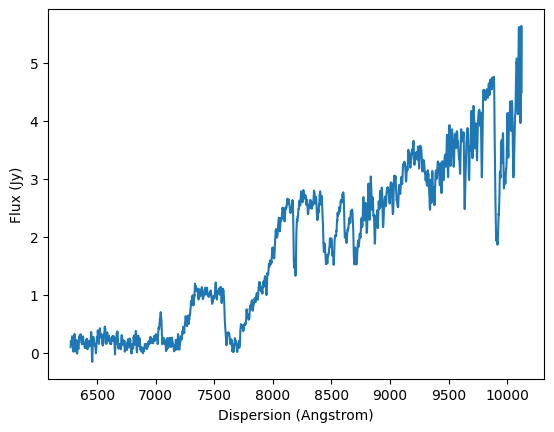

LRIS_1333p2735.txt is plottable
Reading mosfire spectra mosfire_NIR_Wolf1130B.txt


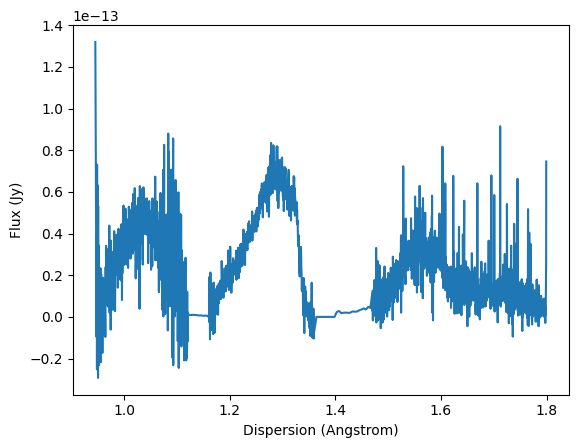

mosfire_NIR_Wolf1130B.txt is plottable


In [7]:
# process mosfire and LRIS with NIR spectra --
for filename in os.listdir(path):
    if filename.startswith("LRIS"):
        print(f"Reading LRIS spectra {filename}")

        data = np.loadtxt(os.path.join(path, filename))
        wavelength = data[:, 0] * u.Angstrom
        flux = data[:, 1] * u.Jy
        spectrum = Spectrum1D(flux=flux, spectral_axis=wavelength)
        if check_spectrum_plottable(spectrum, show_plot=True):
            print(f"{filename} is plottable")
    
    elif filename.startswith("mosfire"):
        print(f"Reading mosfire spectra {filename}")
        data = np.loadtxt(os.path.join(path, filename))
        wavelength = data[:, 0] * u.Angstrom
        flux = data[:, 1] * u.Jy
        spectrum = Spectrum1D(flux=flux, spectral_axis=wavelength)
        if check_spectrum_plottable(spectrum, show_plot=    True):
            print(f"{filename} is plottable")

Reading NIRSPEC spectra NIR_J1810-1009.txt


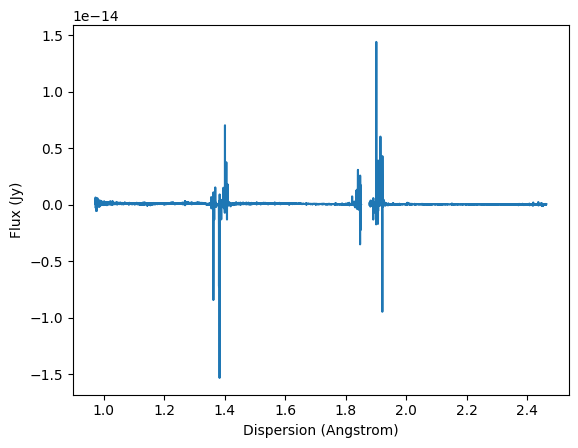

NIR_J1810-1009.txt is plottable

Reading NIRSPEC spectra NIR_J1316+0755_Burn2014.txt


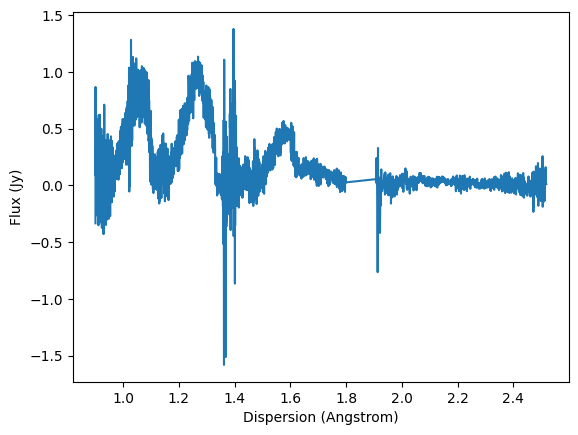

NIR_J1316+0755_Burn2014.txt is plottable



In [135]:
# handle NIR spectra with txt file --
for filename in os.listdir(path):
    if filename.startswith("NIR") and filename.endswith(".txt"):
        print(f"Reading NIRSPEC spectra {filename}")
        # data = np.loadtxt(os.path.join(path, filename), skiprows=2)
        data = np.genfromtxt(
            os.path.join(path, filename),
            skip_header=2
        )
        wavelength = data[:, 0] * u.Angstrom
        flux = data[:, 1] * u.Jy
        spectrum = Spectrum1D(flux=flux, spectral_axis=wavelength)
        #spectrum = extract_region(spectrum, SpectralRegion(0.9*u.um, 1.3*u.um))
        if check_spectrum_plottable(spectrum, show_plot=True):
            print(f"{filename} is plottable\n")

Reading NIRSPEC spectra nirspec_0014m0838.txt


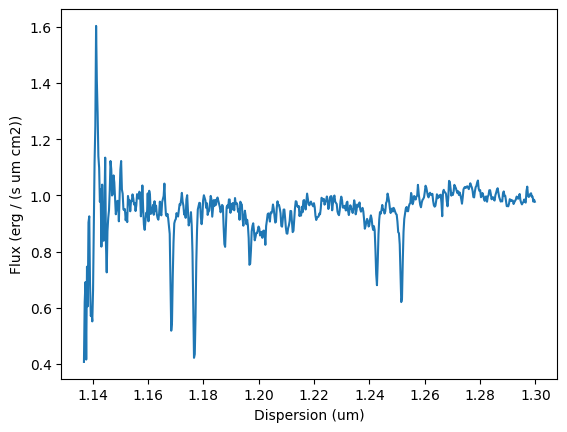

nirspec_0014m0838.txt is plottable



In [158]:
# other case for NIRSPEC txt file
for filename in os.listdir(path):
    if filename.startswith("nirspec") and filename.endswith(".txt"):
        print(f"Reading NIRSPEC spectra {filename}")

        data = np.genfromtxt(
            os.path.join(path, filename),
            skip_header=8,
        )
        data = data[~np.isnan(data).any(axis=1)]

        wavelength = data[:, 0] * u.um
        flux = data[:, 1] * (u.erg / u.cm**2 / u.s / u.um)

        spectrum = Spectrum1D(flux=flux, spectral_axis=wavelength)
        # the spectra in paper is normalized to 1.28nm
        spectrum = extract_region(spectrum, SpectralRegion(0*u.um, 1.3*u.um))

        if check_spectrum_plottable(spectrum, show_plot=True):
            print(f"{filename} is plottable\n")

Reading NIRSPEC spectra nires_NIR_J1553+6934_20200707.txt


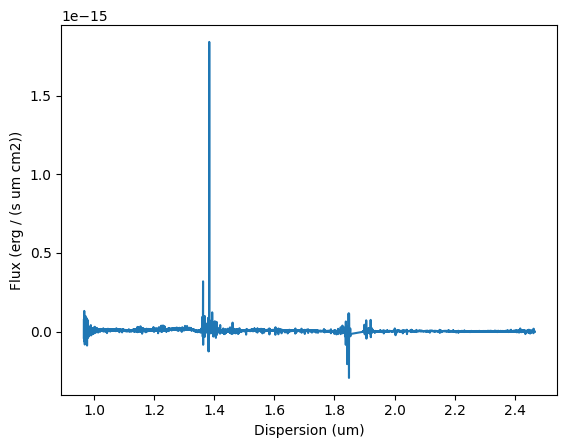

nires_NIR_J1553+6934_20200707.txt is plottable

Reading NIRSPEC spectra nires_NIR_GJ576B_20220611.txt


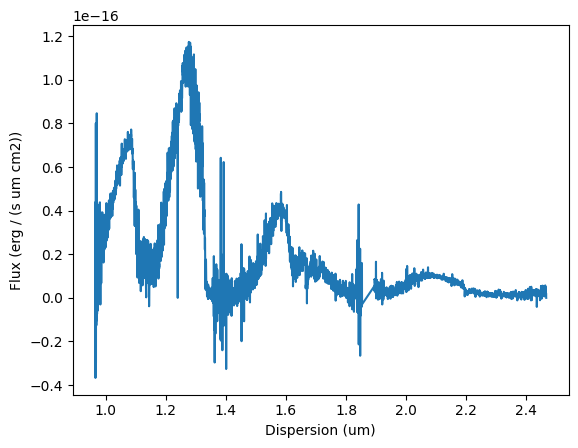

nires_NIR_GJ576B_20220611.txt is plottable



In [156]:
# other case for NIRSPEC txt file, special case for this two plot -- ValueError: Spectral axis must be strictly increasing or decreasing.
for filename in os.listdir(path):
    if filename.startswith("nires") and filename.endswith(".txt"):
        print(f"Reading NIRSPEC spectra {filename}")

        data = np.genfromtxt(
            os.path.join(path, filename),
            skip_header=8,
        )
        # sort and remove NULL data value
        data = data[~np.isnan(data).any(axis=1)]
        data = data[np.argsort(data[:, 0])]

        wavelength = data[:, 0] * u.um
        flux = data[:, 1] * (u.erg / u.cm**2 / u.s / u.um)

        spectrum = Spectrum1D(flux=flux, spectral_axis=wavelength)

        if check_spectrum_plottable(spectrum, show_plot=True):
            print(f"{filename} is plottable\n")

Reading nires_NIR_J0532+8246_20220119.csv


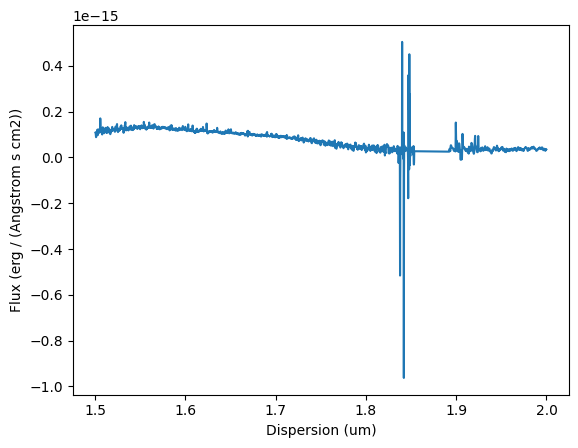

nires_NIR_J0532+8246_20220119.csv is plottable



In [124]:
# handle NIRspec with csv file --- cannot compare with research paper as still in preparation
for filename in os.listdir(path):
    if filename.endswith(".csv") and (filename.startswith("nires")):
        file_path = os.path.join(path, filename)
        print(f"Reading {filename}")
        
        data = np.genfromtxt(file_path, delimiter=",", skip_header=1)

        wavelength = data[:, 0] * u.um
        flux = data[:, 1] * (u.erg / u.cm**2 / u.s / u.AA)

        spectrum = Spectrum1D(flux=flux, spectral_axis=wavelength)
        spectrum = extract_region(spectrum, SpectralRegion(1.5*u.um, 2*u.um))

        # Check if the prism spectrum is plottable
        if (check_spectrum_plottable(spectrum ,show_plot=True)):
            print(f"{filename} is plottable\n")


Reading NIR_J0850-0221.csv


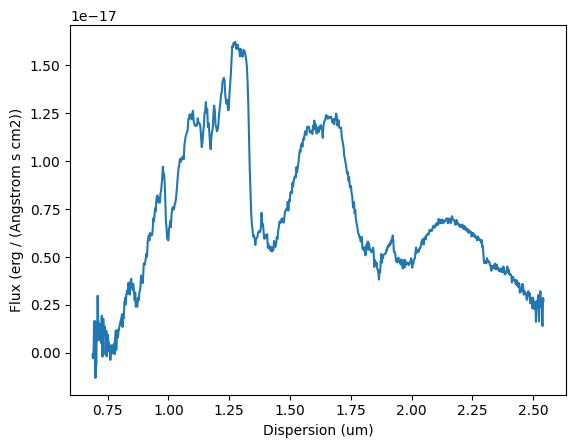

NIR_J0850-0221.csv is plottable

Reading NIR_J0948-2903.csv


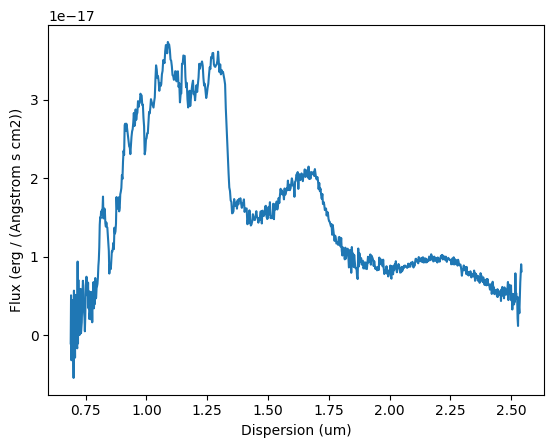

NIR_J0948-2903.csv is plottable

Reading NIR_J1820+2021.csv


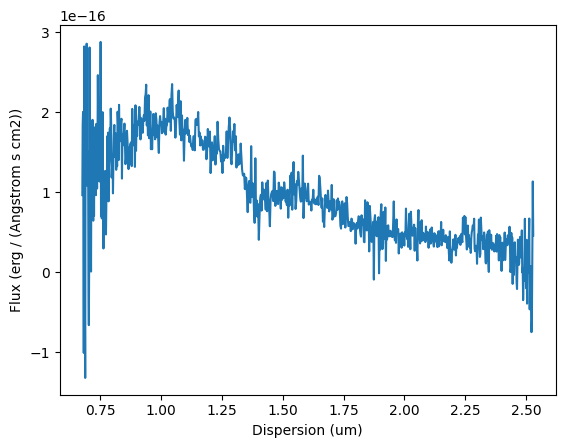

NIR_J1820+2021.csv is plottable

Reading NIR_J1552+0951.csv


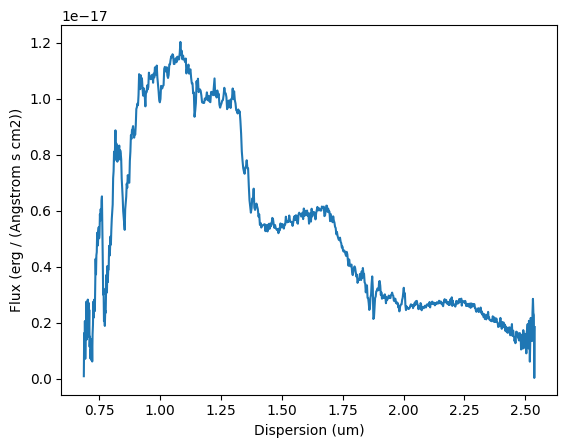

NIR_J1552+0951.csv is plottable

Reading NIR_J1219+0810.csv


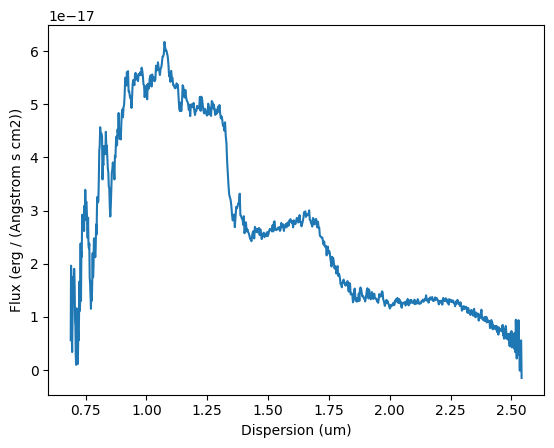

NIR_J1219+0810.csv is plottable

Reading NIR_J1440-2225.csv


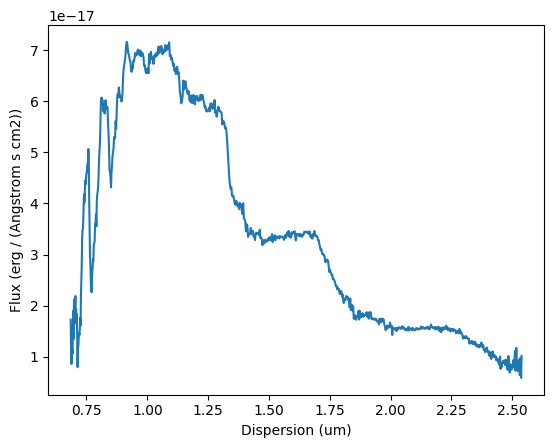

NIR_J1440-2225.csv is plottable

Reading NIR_J1245+6016.csv


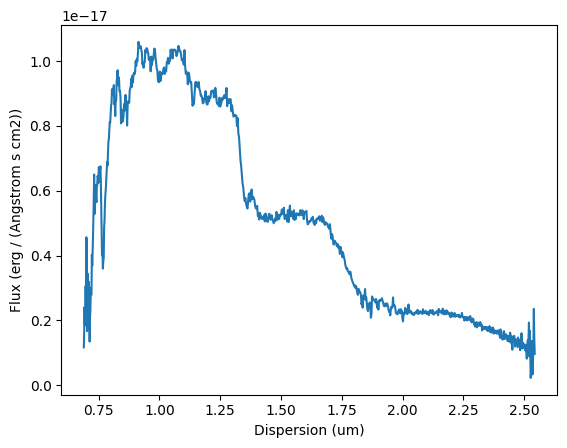

NIR_J1245+6016.csv is plottable

Reading NIR_J0301-2319.csv


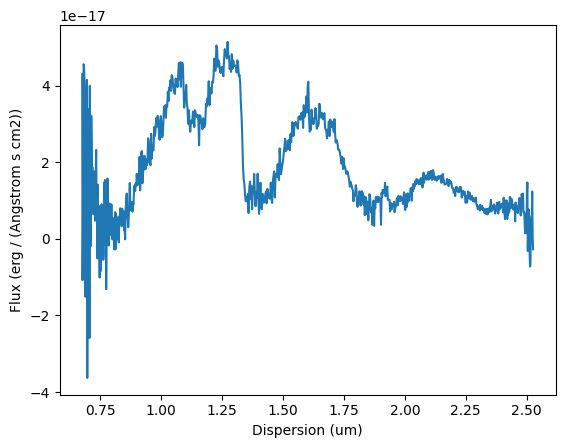

NIR_J0301-2319.csv is plottable

Reading NIR_J1439-1100.csv


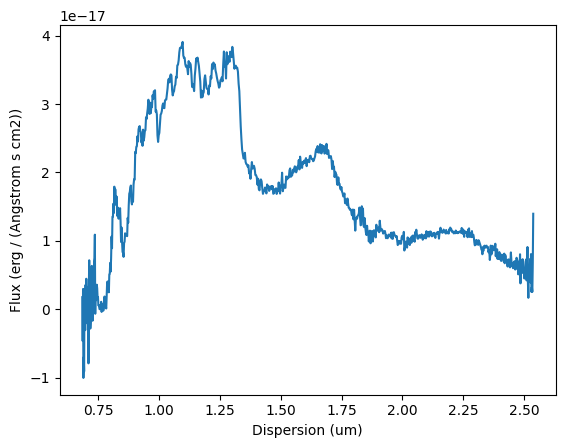

NIR_J1439-1100.csv is plottable

Reading NIR_J1220+6205.csv


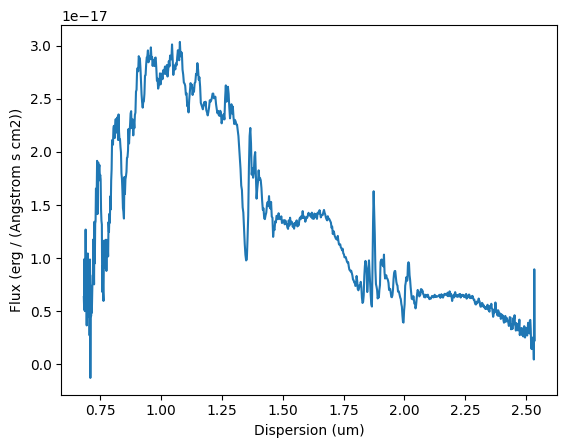

NIR_J1220+6205.csv is plottable

Reading NIR_J1035-0771.csv


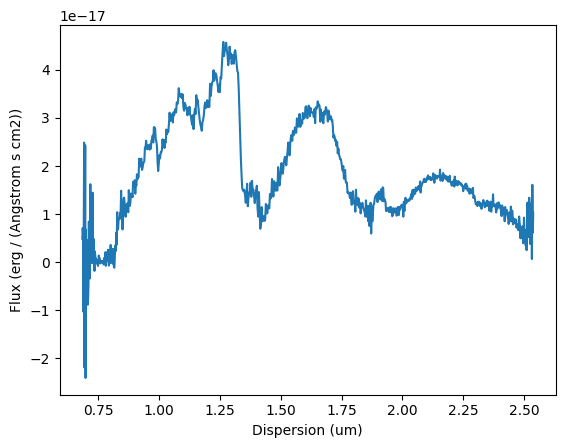

NIR_J1035-0771.csv is plottable

Reading NIR_J0004-2604.csv


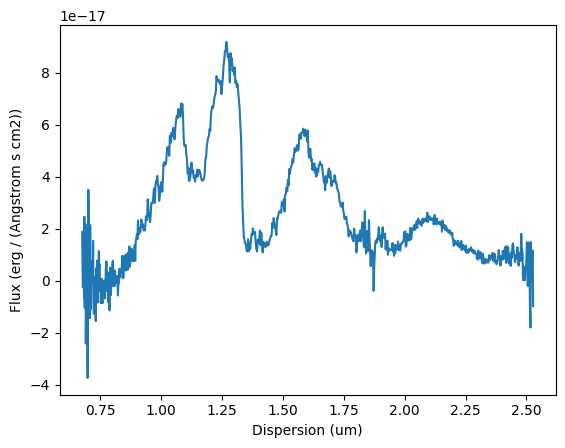

NIR_J0004-2604.csv is plottable

failed file: 0
plotted file: 12


In [121]:
# handle NIRspec with csv file ---
file_failed = 0
file_plotted = 0
for filename in os.listdir(path):
    if filename.endswith(".csv") and (filename.startswith("NIR")):
        file_path = os.path.join(path, filename)
        print(f"Reading {filename}")
        
        data = np.genfromtxt(file_path, delimiter=",", skip_header=1)

        wavelength = data[:, 0] * u.um
        flux = data[:, 1] * (u.erg / u.cm**2 / u.s / u.AA)

        spectrum = Spectrum1D(flux=flux, spectral_axis=wavelength)

        # Check if the prism spectrum is plottable
        if (check_spectrum_plottable(spectrum ,show_plot=True)):
            print(f"{filename} is plottable\n")
            file_plotted += 1
        else:
            file_failed += 1

print(f"failed file: {file_failed}")
print(f"plotted file: {file_plotted}")
        